In [1]:
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np

import copy
import time
from scipy import integrate

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [3]:
lats = np.linspace(-90, 90, 361)
lons = np.linspace(-180, 179.375, 576)
levels = [1000, 975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 650, 600, 550, 500, 450, 400, 350, 300,
          250, 200, 150, 100, 70, 50, 40, 30, 20, 10, 7, 5, 4, 3, 2, 1, .7, .5, .4, .3, .1]

geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g

### WGET command to download

wget --content-disposition --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies --content-disposition -i merra_links_list.txt 

In [5]:
merra_data = xr.open_mfdataset('raw_data/MERRA2_*2022*')

#Let's only select through 2021, the last full year
merra_data = merra_data#.sel(time=slice('1980-01-01', '2021-12-31'))

merra_data

<xarray.Dataset>
Dimensions:   (time: 12, lat: 361, lon: 576, lev: 42)
Coordinates:
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lev       (lev) float64 1e+03 975.0 950.0 925.0 900.0 ... 0.5 0.4 0.3 0.1
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time      (time) datetime64[ns] 2022-01-01 2022-02-01 ... 2022-12-01
Data variables:
    PS        (time, lat, lon) float32 dask.array<chunksize=(1, 361, 576), meta=np.ndarray>
    Cov_V_T   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    V         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    T         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    Cov_V_H   (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    QV        (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    Cov_V_QV  (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
    H         (time, lev, lat, lon) float32 dask.array<chunksize=(1, 42, 361, 576), meta=np.ndarray>
Attributes: (12/32)
    Contact:                           http://gmao.gsfc.nasa.gov
    History:                           Original file generated: Sat Feb 26 01...
    Filename:                          MERRA2_400.instM_3d_asm_Np.202201.nc4
    Comment:                           GMAO filename: d5124_m2_jan10.inst3_3d...
    Source:                            CVS tag: GEOSadas-5_12_4_p32_SLES12_M2...
    Conventions:                       CF-1
    ...                                ...
    DataResolution:                    0.5 x 0.625 (42 pressure levels)
    identifier_product_doi:            10.5067/2E096JV59PK7
    RangeBeginningTime:                00:00:00.000000
    RangeEndingTime:                   21:00:00.000000
    DODS_EXTRA.Unlimited_Dimension:    time
    history:                           2023-03-06 17:18:21 GMT Hyrax-1.16.3 h...

In [5]:
#First get the weights

levels_array = np.array(levels[::-1]) #NOTE: WE flip the level array here
mlev = (levels_array[:-1] + levels_array[1:]) / 2
new_mlev = np.append(np.insert(mlev, 0, 0), 1000)
#Now we have the generic edges of our level boxes

WEIGHT = np.empty((len(levels), len(lats), len(lons)))
ps = merra_data.PS.mean('time').values / 100 #To get in hPa

for i in range(len(lats)):
    for j in range(len(lons)):
        
        #This looks and first makes sure that the level at each point is not below the surface pressure
        #If a point is below ths surface pressure, it gets converted to the surface pressure
        #Then we subtract out the original neighboring levels
        #This will result in some level boxes getting negative weight (where surface pressure was used)
        #So, we change those values to 0
        #Then we deal with converting hPa to Pa and making units work with g
        WEIGHT[:,i,j] = np.maximum(np.minimum(new_mlev[1:], ps[i,j] * np.ones(len(levels))) - new_mlev[:-1],
                                   np.zeros(len(levels))) * 100 / g

#This is our generic weighting, used later
weight = (new_mlev[:-1] - new_mlev[1:]) * 100 / g

In [6]:
#This is basically just making a topography maks

tmask = np.ones((len(levels), len(lats), len(lons)))
TMASK = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        lon_idxs = np.where(ps[j,:] < new_mlev[i+1])

        tmask[i,j,lon_idxs] = 0
        TMASK[i,j,lon_idxs] = np.nan

In [7]:
#This is the weighting for each point, allowing for us to take zonal averages more easily

ZON_NORM = np.ones((len(levels), len(lats), len(lons)))

for i in range(len(levels)):
    for j in range(len(lats)):
        ZON_NORM[i,j,:] = WEIGHT[i,j,:] / np.maximum(np.sum(WEIGHT[i,j,:]), 1e-5)

In [8]:
#And zonal weights, useful for AHT where we have zonal-mean quantities

ZON_WEIGHT = np.ones((len(levels), len(lats)))

for i in range(len(levels)):
    ZON_WEIGHT[i,:] = np.mean(WEIGHT[i,:,:], axis=1)

### Now, let's save out all the weighting info to a netcdf

In [9]:
WEIGHT_attrs = 'Weighting for each grid cell. Not normalized.'
weight_attrs = 'Generic weighting for the column. Does not account for surface pressure.'
TMASK_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or nan if below. Unitless.'
tmask_attrs = 'Simple mask where points are 1 if above time-mean surface pressure, or 0 if below. Unitless.'
ZON_NORM_attrs = 'Basically a normalized version of WEIGHT, where the normalization is over longitude. To take a zonal average, multiply a quantity by this and sum along the longitude dimenion. Unitless.'
ZON_WEIGHT_attrs = 'Zonal average weight.'

weighting_ds = xr.Dataset(
                    data_vars = dict(
                        WEIGHT=(['level','latitude','longitude'], WEIGHT, {'Description':WEIGHT_attrs, 'units':'kg/m^2'}),
                        weight=(['level'], weight, {'Description':weight_attrs, 'units':'kg/m^2'}),
                        TMASK=(['level','latitude','longitude'], TMASK, {'Description':TMASK_attrs, 'units':'Unitless'}),
                        tmask=(['level','latitude','longitude'], tmask, {'Description':tmask_attrs, 'units':'Unitless'}),
                        ZON_NORM=(['level','latitude','longitude'], ZON_NORM, {'Description':ZON_NORM_attrs, 'units':'Unitless'}),
                        ZON_WEIGHT=(['level','latitude'], ZON_WEIGHT, {'Description':ZON_WEIGHT_attrs, 'units':'kg/m^2'}),
                    ),
                    coords=dict(
                        level=levels[::-1],
                        latitude=lats,
                        longitude=lons)
)

#weighting_ds.to_netcdf('merra_aht_weights.nc')

In [21]:
weighting_ds = xr.open_dataset('merra_aht_weights.nc')
ZON_NORM = weighting_ds.ZON_NORM.values
ZON_WEIGHT = weighting_ds.ZON_WEIGHT.values
WEIGHT = weighting_ds.WEIGHT.values
weight = weighting_ds.weight.values

### Extrapolate MERRA data so it's more like other reanalysis

In [7]:
def extrap_nans(da, extrap_method):
    levels = da.lev.values

    nan_idxs = np.isnan(da)
    
    no_nans = da.dropna('lev')
    
    interped = no_nans.interp(lev=levels,method=extrap_method,kwargs={"fill_value": "extrapolate"})
    
    new_data = xr.where(nan_idxs, interped, da)
    #new_da = da.copy(data=new_data)
    
    return new_data

In [8]:
extrap_method='linear'
merra_data['V'] = extrap_nans(merra_data.V, extrap_method)
merra_data['QV'] = extrap_nans(merra_data.QV, extrap_method)
merra_data['T'] = extrap_nans(merra_data.T, extrap_method)
merra_data['H'] = extrap_nans(merra_data.H, extrap_method)

merra_data['Cov_V_T'] = extrap_nans(merra_data.Cov_V_T, extrap_method)
merra_data['Cov_V_QV'] = extrap_nans(merra_data.Cov_V_QV, extrap_method)
merra_data['Cov_V_H'] = extrap_nans(merra_data.Cov_V_H, extrap_method)


### Then let's find the near-surface MSE, which we'll later add to the AHT ds

In [9]:
merra_data['mse_surf'] = merra_data.T*cp + merra_data.QV*L

In [14]:
merra_mse_zonal = np.sum(merra_data.mse_surf * ZON_NORM[None,:,:,:], axis=3)

In [15]:
merra_mse_zonal_values = merra_mse_zonal.values

In [16]:
ZON_WEIGHT_normed = ZON_WEIGHT / np.amax(ZON_WEIGHT,axis=1)[:,None]

#Basically saying we need data for half the points at a lat/height to not nan it
ZON_WEIGHT_normed[ZON_WEIGHT_normed < 0.5] = np.nan

bottom_idxs = len(levels) - (~np.isnan(ZON_WEIGHT_normed)).cumsum(0).argmax(0)

In [17]:
merra_data_mse_surf = np.zeros((len(merra_data.time),len(lats)))

for i in range(len(lats)):
    merra_data_mse_surf[:,i] = merra_mse_zonal_values[:,bottom_idxs[i],i]

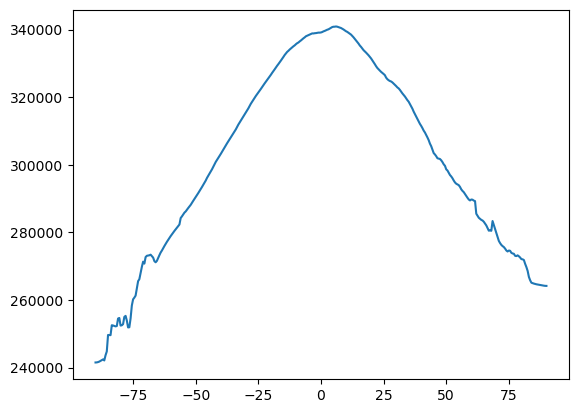

In [18]:
plt.plot(lats, np.mean(merra_data_mse_surf, axis=0))

plt.show()

### Now calculate AHT

In [19]:
def aht_merra(time_idx, correct_mass=True):
    
    #For consistency, we will extrapolate all datasets beneath the surface
    #Can specify different interpolation/extrapolation methods if desired
    #It shouldn't really matter which method is chosen
    #Load in the data and flip the level dimension, since we did this for the weighting too
    extrap_method='linear'
    v = merra_data.V.isel(time=time_idx).values[::-1,:,:]
    t = merra_data.T.isel(time=time_idx).values[::-1,:,:]
    q = merra_data.QV.isel(time=time_idx).values[::-1,:,:]
    z = merra_data.H.isel(time=time_idx).values[::-1,:,:]
    
    vt = merra_data.Cov_V_T.isel(time=time_idx).values[::-1,:,:]
    vq = merra_data.Cov_V_QV.isel(time=time_idx).values[::-1,:,:]
    vz = merra_data.Cov_V_H.isel(time=time_idx).values[::-1,:,:]


    #Now get rid of nans everywhere
    WEIGHT[np.isnan(v)] = 0
    WEIGHT[np.isnan(t)] = 0
    WEIGHT[np.isnan(q)] = 0
    WEIGHT[np.isnan(z)] = 0

    v[np.isnan(v)] = 0
    t[np.isnan(t)] = 0
    q[np.isnan(q)] = 0
    z[np.isnan(z)] = 0
    vt[np.isnan(vt)] = 0
    vq[np.isnan(vq)] = 0
    vz[np.isnan(vz)] = 0

    #Convert everything to the same MSE units
    SE = cp * t
    PE = g * z
    ME = L * q
    MSE = SE + PE + ME
    
    #Find zonal-averages
    SE_bar = np.sum(ZON_NORM * SE, axis=2)
    ME_bar = np.sum(ZON_NORM * ME, axis=2)
    PE_bar = np.sum(ZON_NORM * PE, axis=2)
    V_bar = np.sum(ZON_NORM * v, axis=2)
    E_bar = np.sum(ZON_NORM * MSE, axis=2)

    #Then find zonal anomalies
    Ve = v - V_bar[:,:,None]
    SEe = SE - SE_bar[:,:,None]
    MEe = ME - ME_bar[:,:,None]
    PEe = PE - PE_bar[:,:,None]
    
    #Multiply zonal-anomalies to get the SE piece
    #_map is just referring to plan view, ie before zonal averaging occurs
    #Dividing the WEIGHT by weight, normalizes things
    VSEse_map = (Ve * SEe) * (WEIGHT / weight[:,None,None])
    VMEse_map = (Ve * MEe) * (WEIGHT / weight[:,None,None])
    VPEse_map = (Ve * PEe) * (WEIGHT / weight[:,None,None])
    
    #Get the SEs
    VSEse_bar = np.mean(VSEse_map, axis=2)
    VMEse_bar = np.mean(VMEse_map, axis=2)
    VPEse_bar = np.mean(VPEse_map, axis=2)
    
    #Now do the TEs
    #Magically, MERRA2 outputs vt, vq, and vz, just the way we want them (with means removed)
    #So, follow same formula as SEs     
    VSEte_map = (vt * cp) * (WEIGHT / weight[:,None,None])
    VMEte_map = (vq * L) * (WEIGHT / weight[:,None,None])
    VPEte_map = (vz * g) * (WEIGHT / weight[:,None,None])

    VSEte_bar = np.mean(VSEte_map, axis=2)
    VMEte_bar = np.mean(VMEte_map, axis=2)
    VPEte_bar = np.mean(VPEte_map, axis=2)
        
    #Account for non-zero mass transport in the MMC by removing the vertically averaged v and MSE
    V_vert_ave = np.sum(V_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    E_vert_ave = np.sum(E_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    ME_vert_ave = np.sum(ME_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    PE_vert_ave = np.sum(PE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    SE_vert_ave = np.sum(SE_bar * (ZON_WEIGHT / np.sum(ZON_WEIGHT, axis=0)[None,:]), axis=0)
    
    if correct_mass == True:
        V_bar_new = V_bar - V_vert_ave[None,:]
        E_bar_new = E_bar - E_vert_ave[None,:]
        ME_bar_new = ME_bar - ME_vert_ave[None,:]
        PE_bar_new = PE_bar - PE_vert_ave[None,:]
        SE_bar_new = SE_bar - SE_vert_ave[None,:]
    elif correct_mass == False:
        V_bar_new = V_bar
        E_bar_new = E_bar
        ME_bar_new = ME_bar
        PE_bar_new = PE_bar
        SE_bar_new = SE_bar
    else:
        print('Error with specifying mass correction choice')
        
    #MASS = np.sum(ZON_WEIGHT * V_bar * E_vert_ave[None,:], axis=0)
    MASS = np.sum(ZON_WEIGHT, axis=0) * V_vert_ave * E_vert_ave

    #Now multiply things by the needed weights and sum in the vertical
    MMC = np.sum(ZON_WEIGHT * V_bar_new * E_bar_new, axis=0)
    strm_fnct = np.cumsum((ZON_WEIGHT * V_bar_new), axis=0)[::-1,:]
    MMC_moist = np.sum(ZON_WEIGHT * V_bar_new * ME_bar_new, axis=0)
    MMC_dry = np.sum(ZON_WEIGHT * V_bar_new * SE_bar_new, axis=0)
    MMC_pot = np.sum(ZON_WEIGHT * V_bar_new * PE_bar_new, axis=0)
    
    #MASS_new = np.sum(ZON_WEIGHT * V_bar_new * E_vert_ave[None,:], axis=0)
    
    #SEs and TEs have already accounted for surface orography, so we just use generic weight here
    SE_dry = np.sum(weight[:,None] * VSEse_bar, axis=0)
    SE_pot = np.sum(weight[:,None] * VPEse_bar, axis=0)
    SE_moist = np.sum(weight[:,None] * VMEse_bar, axis=0)
    
    SE = SE_dry + SE_pot + SE_moist
    
    TE_dry = np.sum(weight[:,None] * VSEte_bar, axis=0)
    TE_pot = np.sum(weight[:,None] * VPEte_bar, axis=0)
    TE_moist = np.sum(weight[:,None] * VMEte_bar, axis=0)
    
    TE = TE_dry + TE_pot + TE_moist
    
    return MMC, MMC_moist, MMC_dry, MMC_pot, SE, SE_moist, SE_dry, SE_pot, TE, TE_moist, TE_dry, TE_pot, MASS, strm_fnct, VSEse_bar, VPEse_bar, VMEse_bar, VSEte_bar, VPEte_bar, VMEte_bar, E_bar_new, V_bar_new, SE_bar_new, PE_bar_new, ME_bar_new



In [22]:
num_months = len(merra_data.time)

TEs = np.zeros((num_months, len(lats)))
TEs_moist = np.zeros((num_months, len(lats)))
TEs_dry = np.zeros((num_months, len(lats)))
TEs_pot = np.zeros((num_months, len(lats)))
SEs = np.zeros((num_months, len(lats)))
SEs_moist = np.zeros((num_months, len(lats)))
SEs_dry = np.zeros((num_months, len(lats)))
SEs_pot = np.zeros((num_months, len(lats)))
MMCs = np.zeros((num_months, len(lats)))
MMCs_moist = np.zeros((num_months, len(lats)))
MMCs_dry = np.zeros((num_months, len(lats)))
MMCs_pot = np.zeros((num_months, len(lats)))
MASS_fluxes = np.zeros((num_months, len(lats)))
strm_fncts = np.zeros((num_months, len(levels), len(lats)))
VSEses = np.zeros((num_months, len(levels), len(lats)))
VPEses = np.zeros((num_months, len(levels), len(lats)))
VMEses = np.zeros((num_months, len(levels), len(lats)))
VSEtes = np.zeros((num_months, len(levels), len(lats)))
VPEtes = np.zeros((num_months, len(levels), len(lats)))
VMEtes = np.zeros((num_months, len(levels), len(lats)))
V_bars = np.zeros((num_months, len(levels), len(lats)))
E_bars = np.zeros((num_months, len(levels), len(lats)))
SE_bars = np.zeros((num_months, len(levels), len(lats)))
PE_bars = np.zeros((num_months, len(levels), len(lats)))
ME_bars = np.zeros((num_months, len(levels), len(lats)))

for i in range(num_months):
    values = aht_merra(i)
    MMCs[i,:] = values[0]
    MMCs_moist[i,:] = values[1]
    MMCs_dry[i,:] = values[2]
    MMCs_pot[i,:] = values[3]
    
    SEs[i,:] = values[4]
    SEs_moist[i,:] = values[5]
    SEs_dry[i,:] = values[6]
    SEs_pot[i,:] = values[7]
    
    TEs[i,:] = values[8]
    TEs_moist[i,:] = values[9]
    TEs_dry[i,:] = values[10]
    TEs_pot[i,:] = values[11]
    
    MASS_fluxes[i,:] = values[12]
    
    strm_fncts[i,:,:] = values[13]
    
    VSEses[i,:,:] = values[14]
    VPEses[i,:,:] = values[15]
    VMEses[i,:,:] = values[16]
    
    VSEtes[i,:,:] = values[17]
    VPEtes[i,:,:] = values[18]
    VMEtes[i,:,:] = values[19]
    
    V_bars[i,:,:] = values[20]
    E_bars[i,:,:] = values[21]
    SE_bars[i,:,:] = values[22]
    PE_bars[i,:,:] = values[23]
    ME_bars[i,:,:] = values[24]

In [23]:
TOTs = MMCs + SEs + TEs
TOTs_moist = MMCs_moist + SEs_moist + TEs_moist
TOTs_dry = MMCs_dry + SEs_dry + TEs_dry
TOTs_pot = MMCs_pot + SEs_pot + TEs_pot
TOTs_dry_pot = TOTs_dry + TOTs_pot

TEs_dry_pot = TEs_dry + TEs_pot
SEs_dry_pot = SEs_dry + SEs_pot
MMCs_dry_pot = MMCs_dry + MMCs_pot

EDDYs = SEs + TEs
EDDYs_moist = SEs_moist + TEs_moist
EDDYs_dry = SEs_dry + TEs_dry
EDDYs_pot = SEs_pot + TEs_pot
EDDYs_dry_pot = EDDYs_dry + EDDYs_pot

In [24]:
vert_conversion =  -1000 / g

final_ds = xr.Dataset(
                    data_vars = dict(
                        total_aht=(['time','latitude'], TOTs * (geometry * g)[None,:]),
                        total_aht_dry=(['time','latitude'], TOTs_dry * (geometry * g)[None,:]),
                        total_aht_moist=(['time','latitude'], TOTs_moist * (geometry * g)[None,:]),
                        total_aht_pot=(['time','latitude'], TOTs_pot * (geometry * g)[None,:]),
                        total_aht_dry_pot=(['time','latitude'], TOTs_dry_pot * (geometry * g)[None,:]),
                        mmc_aht=(['time','latitude'], MMCs * (geometry * g)[None,:]),
                        mmc_aht_dry=(['time','latitude'], MMCs_dry * (geometry * g)[None,:]),
                        mmc_aht_moist=(['time','latitude'], MMCs_moist * (geometry * g)[None,:]),
                        mmc_aht_pot=(['time','latitude'], MMCs_pot * (geometry * g)[None,:]),
                        mmc_aht_dry_pot=(['time','latitude'], MMCs_dry_pot * (geometry * g)[None,:]),
                        se_aht=(['time','latitude'], SEs * (geometry * g)[None,:]),
                        se_aht_dry=(['time','latitude'], SEs_dry * (geometry * g)[None,:]),
                        se_aht_moist=(['time','latitude'], SEs_moist * (geometry * g)[None,:]),
                        se_aht_pot=(['time','latitude'], SEs_pot * (geometry * g)[None,:]),
                        se_aht_dry_pot=(['time','latitude'], SEs_dry_pot * (geometry * g)[None,:]),
                        te_aht=(['time','latitude'], TEs * (geometry * g)[None,:]),
                        te_aht_dry=(['time','latitude'], TEs_dry * (geometry * g)[None,:]),
                        te_aht_moist=(['time','latitude'], TEs_moist * (geometry * g)[None,:]),
                        te_aht_pot=(['time','latitude'], TEs_pot * (geometry * g)[None,:]),
                        te_aht_dry_pot=(['time','latitude'], TEs_dry_pot * (geometry * g)[None,:]),
                        eddy_aht=(['time','latitude'], EDDYs * (geometry * g)[None,:]),
                        eddy_aht_dry=(['time','latitude'], EDDYs_dry * (geometry * g)[None,:]),
                        eddy_aht_moist=(['time','latitude'], EDDYs_moist * (geometry * g)[None,:]),
                        eddy_aht_pot=(['time','latitude'], EDDYs_pot * (geometry * g)[None,:]),
                        eddy_aht_dry_pot=(['time','latitude'], EDDYs_dry_pot * (geometry * g)[None,:]),
                        mass=(['time','latitude'], MASS_fluxes * (geometry * g)[None,:]),
                        mse_surf=(['time','latitude'], merra_data_mse_surf),
                        strm_fnct=(['time','level','latitide'], strm_fncts * g * geometry[None,None,:]),
                        VSEse=(['time','level','latitude'], VSEses * -1000 * g**2 * geometry[None,None,:]),
                        VPEse=(['time','level','latitude'], VPEses * -1000 * g**2 * geometry[None,None,:]),
                        VMEse=(['time','level','latitude'], VMEses * -1000 * g**2 * geometry[None,None,:]),
                        VSEte=(['time','level','latitude'], VSEtes * -1000 * g**2 * geometry[None,None,:]),
                        VPEte=(['time','level','latitude'], VPEtes * -1000 * g**2 * geometry[None,None,:]),
                        VMEte=(['time','level','latitude'], VMEtes * -1000 * g**2 * geometry[None,None,:]),
                        V_bar=(['time','level','latitude'], V_bars),
                        E_bar=(['time','level','latitude'], E_bars),
                        ME_bar=(['time','level','latitude'], ME_bars),
                        PE_bar=(['time','level','latitude'], PE_bars),
                        SE_bar=(['time','level','latitude'], SE_bars),
                    ),
                    coords=dict(
                        time=merra_data.time,
                        level=levels,
                        latitude=lats,)
)

#final_ds.to_netcdf('merra_aht_2022.nc')

In [28]:
orig_ds = xr.open_dataset('merra_aht.nc')

full_ds = xr.concat([orig_ds, final_ds], dim='time')

#full_ds.to_netcdf('merra_aht_1980_2022.nc')

In [25]:
old_ds = xr.open_dataset('merra_aht.nc')

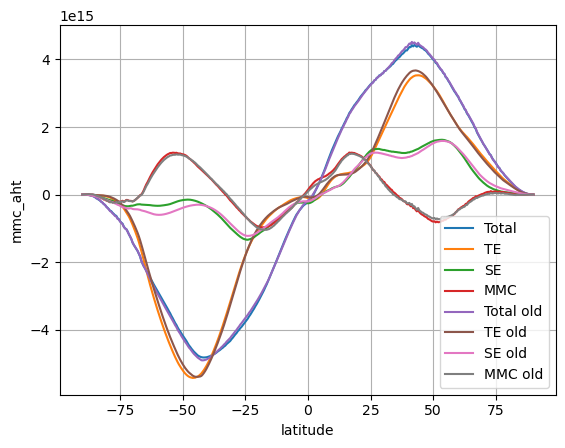

In [26]:
(final_ds.total_aht.mean('time')).plot(label='Total')
(final_ds.te_aht.mean('time')).plot(label='TE')
(final_ds.se_aht.mean('time')).plot(label='SE')
(final_ds.mmc_aht.mean('time')).plot(label='MMC')

(old_ds.total_aht.mean('time')).plot(label='Total old')
(old_ds.te_aht.mean('time')).plot(label='TE old')
(old_ds.se_aht.mean('time')).plot(label='SE old')
(old_ds.mmc_aht.mean('time')).plot(label='MMC old')

plt.grid()

plt.legend(loc=0)

plt.show()

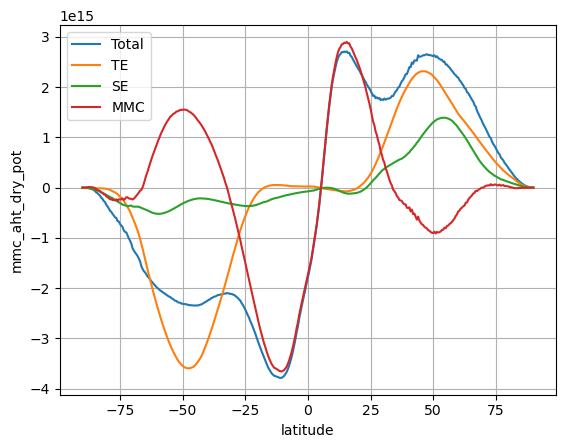

In [63]:
(final_ds.total_aht_dry_pot.mean('time')).plot(label='Total')
(final_ds.te_aht_dry_pot.mean('time')).plot(label='TE')
(final_ds.se_aht_dry_pot.mean('time')).plot(label='SE')
(final_ds.mmc_aht_dry_pot.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

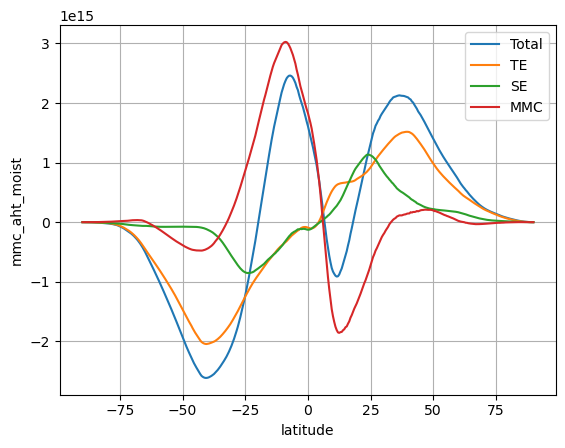

In [64]:
(final_ds.total_aht_moist.mean('time')).plot(label='Total')
(final_ds.te_aht_moist.mean('time')).plot(label='TE')
(final_ds.se_aht_moist.mean('time')).plot(label='SE')
(final_ds.mmc_aht_moist.mean('time')).plot(label='MMC')

plt.grid()

plt.legend(loc=0)

plt.show()

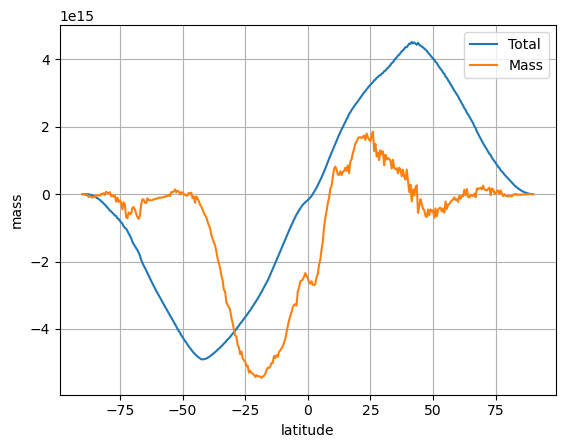

In [65]:
(final_ds.total_aht.mean('time')).plot(label='Total')
(final_ds.mass.mean('time')).plot(label='Mass')

plt.grid()

plt.legend(loc=0)

plt.show()

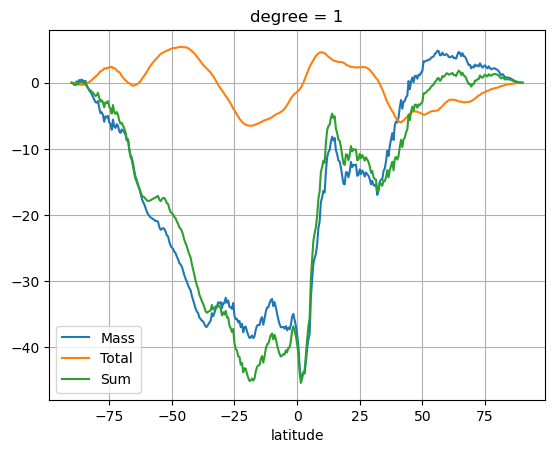

In [66]:
trends_ds = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
(trends_ds.mass_polyfit_coefficients.sel(degree=1) / 1e12).plot(label='Mass')
(trends_ds.total_aht_polyfit_coefficients.sel(degree=1) / 1e12).plot(label='Total')

((trends_ds.total_aht_polyfit_coefficients + trends_ds.mass_polyfit_coefficients).sel(degree=1) / 1e12).plot(label='Sum')
plt.legend(loc=0)
plt.grid()
plt.show()

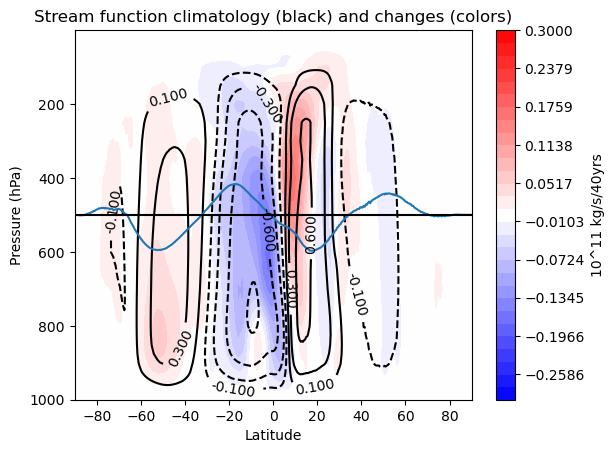

In [67]:
clima_strm = final_ds.strm_fnct.mean(['time'])

which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]
#which_levels = range(-15, 16)
#which_levels = [-15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1,
                #1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
cont=plt.contour(lats, levels, clima_strm/1e11, levels=which_levels, colors='k')

contf = plt.contourf(lats, levels, trends_ds.strm_fnct_polyfit_coefficients.sel(degree=1) * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')

plt.colorbar(contf, label='10^11 kg/s/40yrs')

plt.gca().invert_yaxis()

def fmt(x):
    #rounded = f"{x:-2f}"
    rounded = f"{x:1f}"
    return rounded

#plt.clabel(cont, cont.levels, inline=True, fmt='%2.f', fontsize=10)
plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

#plt.axhline(700)
#plt.axvline(-12)

#plt.xlim([-50, 50])
plt.xlabel('Latitude')
plt.ylabel('Pressure (hPa)')

plt.title('Stream function climatology (black) and changes (colors)')

plt.plot(lats, (final_ds.mmc_aht.mean('time') * 80 / 1e15) + 500)
plt.axhline(500, color='k')
#plt.savefig('../figures/aht_trends/merra_stream_function_clima_and_changes')

plt.show()

In [68]:
def trend(x):
    return x.polyfit('time', deg=1)

#Output is in W/ns, so we convert to PW/40yrs
merra_month = final_ds.groupby('time.month').mean('time')
merra_trends_month = final_ds.groupby('time.month').apply(trend)  * 1e9 * 3600 * 24 * 365 * 40

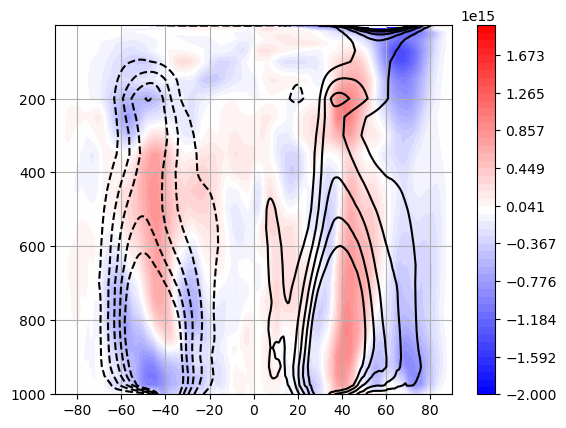

In [69]:
which_month = 2
te_tot = merra_month.VSEte + merra_month.VPEte + merra_month.VMEte
se_tot = merra_month.VSEse + merra_month.VPEse + merra_month.VMEse

eddy_tot = se_tot + te_tot

te_tot_trend = merra_trends_month.VSEte_polyfit_coefficients + merra_trends_month.VPEte_polyfit_coefficients + merra_trends_month.VMEte_polyfit_coefficients
se_tot_trend = merra_trends_month.VSEse_polyfit_coefficients + merra_trends_month.VPEse_polyfit_coefficients + merra_trends_month.VMEse_polyfit_coefficients

eddy_tot_trend = se_tot_trend + te_tot_trend

#plt.contour(lats, levels[::-1], te_tot.sel(month=which_month) * (weight[:,None]) * 1000 / (-weight[:,None] / g) / 1e15,
             #levels=[ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5], colors='k')

plt.contour(lats, levels[::-1], te_tot.sel(month=which_month) / 1e15,
             levels=[ -5, -4, -3, -2, -1, 1, 2, 3, 4, 5], colors='k')

#plt.contourf(lats, levels[::-1], te_tot_trend.sel(degree=1).sel(month=which_month) * (weight[:,None]) * 1000 / (-weight[:,None] / g),
             #levels=np.linspace(-2e15, 2e15, 50), cmap='bwr')

plt.contourf(lats, levels[::-1], te_tot_trend.sel(degree=1).sel(month=which_month),
             levels=np.linspace(-2e15, 2e15, 50), cmap='bwr')
plt.colorbar()

plt.gca().invert_yaxis()

plt.grid()

plt.show()

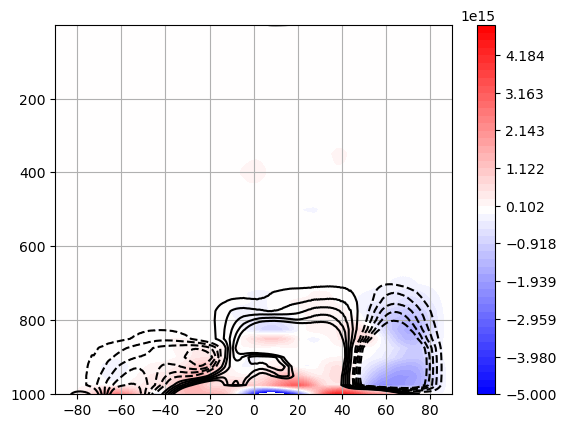

In [70]:
which_month = 2


mmc_month = merra_month.E_bar * merra_month.V_bar * ZON_WEIGHT
mmc_month_trend = merra_trends_month.E_bar_polyfit_coefficients * merra_trends_month.V_bar_polyfit_coefficients * ZON_WEIGHT


plt.contour(lats, levels, mmc_month.sel(month=which_month) * geometry[None,:] * g * 1000 / (-weight[:,None] / g) / 1e15,
             levels=[-50, -40, -30, -20, -10, 10, 20, 30 , 40, 50], colors='k')

plt.contourf(lats, levels, mmc_month_trend.sel(degree=1).sel(month=which_month) * geometry[None,:] * g * 1000 / (-weight[:,None] / g),
             levels=np.linspace(-5e15, 5e15, 50), cmap='bwr')

plt.colorbar()

plt.gca().invert_yaxis()

plt.grid()

plt.show()

In [80]:
#final_ds.total_aht.sel(time=slice('2000-01-01', '2018-12-31')).mean('time').to_netcdf('merra2_total_aht_2000_2018.nc')

In [48]:
orig_ds = xr.open_dataset('merra_aht.nc')


orig_ds['total_aht_dry_pot'] = orig_ds.total_aht_dry + orig_ds.total_aht_pot
orig_ds['te_aht_dry_pot'] = orig_ds.te_aht_dry + orig_ds.te_aht_pot
orig_ds['se_aht_dry_pot'] = orig_ds.se_aht_dry + orig_ds.se_aht_pot
orig_ds['mmc_aht_dry_pot'] = orig_ds.mmc_aht_dry + orig_ds.mmc_aht_pot

orig_ds['eddy_aht'] = orig_ds.te_aht + orig_ds.se_aht
orig_ds['eddy_aht_dry'] = orig_ds.te_aht_dry + orig_ds.se_aht_dry
orig_ds['eddy_aht_moist'] = orig_ds.te_aht_moist + orig_ds.se_aht_moist
orig_ds['eddy_aht_pot'] = orig_ds.te_aht_pot + orig_ds.se_aht_pot
orig_ds['eddy_aht_dry_pot'] = orig_ds.te_aht_dry_pot + orig_ds.se_aht_dry_pot

final_ds['total_aht_dry_pot'] = final_ds.total_aht_dry + final_ds.total_aht_pot
final_ds['te_aht_dry_pot'] = final_ds.te_aht_dry + final_ds.te_aht_pot
final_ds['se_aht_dry_pot'] = final_ds.se_aht_dry + final_ds.se_aht_pot
final_ds['mmc_aht_dry_pot'] = final_ds.mmc_aht_dry + final_ds.mmc_aht_pot

final_ds['eddy_aht'] = final_ds.te_aht + final_ds.se_aht
final_ds['eddy_aht_dry'] = final_ds.te_aht_dry + final_ds.se_aht_dry
final_ds['eddy_aht_moist'] = final_ds.te_aht_moist + final_ds.se_aht_moist
final_ds['eddy_aht_pot'] = final_ds.te_aht_pot + final_ds.se_aht_pot
final_ds['eddy_aht_dry_pot'] = final_ds.te_aht_dry_pot + final_ds.se_aht_dry_pot

In [49]:
orig_trends = orig_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)
new_trends = final_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1)

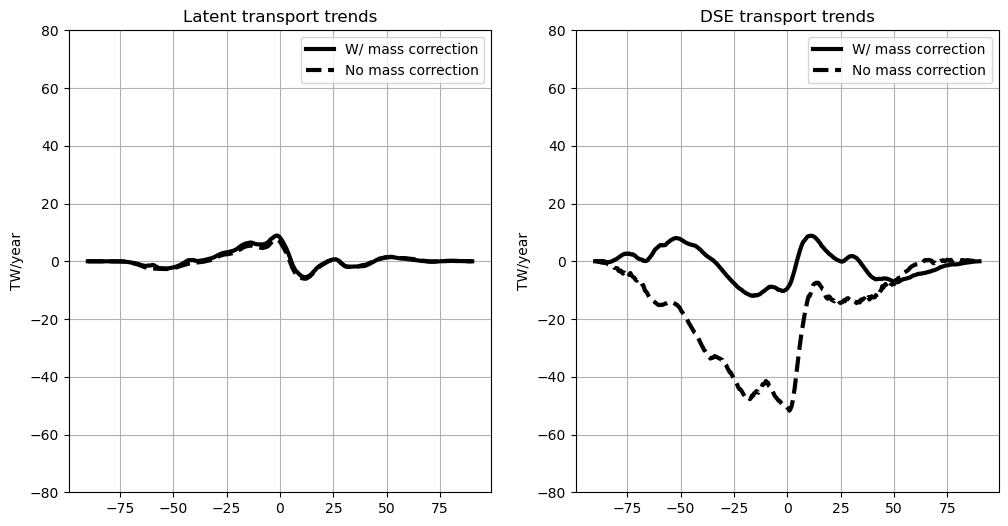

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(lats, (orig_trends.total_aht_moist_polyfit_coefficients.sel(degree=1)/1e12), color='k', lw=3, label='W/ mass correction')
axs[0].plot(lats, (new_trends.total_aht_moist_polyfit_coefficients.sel(degree=1)/1e12), '--', lw=3, color='k',
            label='No mass correction')
axs[0].set_title('Latent transport trends')
axs[0].legend(loc=0)
axs[0].grid()
axs[0].set_ylabel('TW/year')
axs[0].set_ylim([-80, 80])

axs[1].plot(lats, (orig_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1)/1e12), color='k', lw=3, label='W/ mass correction')
axs[1].plot(lats, (new_trends.total_aht_dry_pot_polyfit_coefficients.sel(degree=1)/1e12), '--', lw=3, color='k',
            label='No mass correction')
axs[1].set_title('DSE transport trends')
axs[1].legend(loc=0)
axs[1].grid()
axs[1].set_ylabel('TW/year')
axs[1].set_ylim([-80, 80])

plt.show()